In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import functools

In [3]:
from utilities import *

In [4]:
%matplotlib inline
plt.ioff()
sns.set()
pd.set_option('display.max_columns', 100)

# Part 1: Load the Data

In [5]:
def load_data():    
    df = pd.read_csv('dataset.csv')
    df.set_index(['class', 'id_student'],inplace = True)
    df['year'] = df.code_presentation.str.slice(0,4)
    df['semester'] = df.code_presentation.str.slice(4, 5)
    drop_col(df, 'code_presentation')
    return df

In [6]:
df = load_data()

In [7]:
# Mean imputation for SES
df.imd_band.fillna(df.imd_band.mean(), inplace = True)

In [8]:
# For our first modelling foray, we will juse use the assessment grade.
#  So drop any missing values
drop_by_rule(df, df.grade_Assessment.isna())
drop_col(df, 'grade_Exam')

In [9]:
df.head()

code_module  date_registration  grade_Assessment gender  \
class    id_student                                                           
AAA2013J 11391              AAA             -159.0              82.4      M   
         28400              AAA              -53.0              65.4      F   
         31604              AAA              -52.0              76.3      F   
         32885              AAA             -176.0              55.0      F   
         38053              AAA             -110.0              66.9      M   

                         highest_education  imd_band age_band  \
class    id_student                                             
AAA2013J 11391            HE Qualification      95.0     55<=   
         28400            HE Qualification      25.0    35-55   
         31604       A Level or Equivalent      55.0    35-55   
         32885          Lower Than A Level      55.0     0-35   
         38053       A Level or Equivalent      85.0    35-55   

                     num_of_prev_attempts  studied_credits disability  \
class    id_student                                                     
AAA2013J 11391                          0              240          N   
         28400                          0               60          N   
         31604                          0               60          N   
         32885                          0               60          N   
         38053                          0               60          N   

                     activity_skew  attention_chi_sq_gof  \
class    id_student                                        
AAA2013J 11391            0.741381              2.736682   
         28400            0.334122              0.763697   
         31604            0.256927              0.327877   
         32885            0.849391              2.519574   
         38053           -0.008823              0.338421   

                     attention_hellinger_squared  attention_total_variation  \
class    id_student                                                           
AAA2013J 11391                          0.385076                   0.401765   
         28400                          0.151137                   0.255698   
         31604                          0.124606                   0.200600   
         32885                          0.361038                   0.403652   
         38053                          0.098247                   0.195052   

                     clicks_dataplus  clicks_dualpane  clicks_externalquiz  \
class    id_student                                                          
AAA2013J 11391                   0.0              0.0                  0.0   
         28400                  10.0              0.0                  0.0   
         31604                   2.0              0.0                  0.0   
         32885                   0.0              0.0                  0.0   
         38053                   7.0              0.0                  0.0   

                     clicks_folder  clicks_forumng  clicks_glossary  \
class    id_student                                                   
AAA2013J 11391                 0.0           193.0              0.0   
         28400                 0.0           417.0              0.0   
         31604                 0.0           634.0              1.0   
         32885                 0.0           194.0              4.0   
         38053                 0.0           875.0              4.0   

                     clicks_homepage  clicks_htmlactivity  \
class    id_student                                         
AAA2013J 11391                 138.0                  0.0   
         28400                 324.0                  0.0   
         31604                 432.0                  0.0   
         32885                 204.0                  0.0   
         38053                 512.0                  0.0   

                     clicks_oucollaborate  clicks_

In [10]:
missing = df.isna().sum()
missing[missing != 0]

mean_click_time_from_release    2362
mean_click_time_to_close        2362
dtype: int64

In [11]:
y             = ['grade_Assessment']
X_categorical = ['code_module', 'year', 'semester', 'disability', 'gender', 'highest_education', 'age_band']
X_continuous  = df.columns.tolist()
for col in y + X_categorical:
    X_continuous.remove(col)

# Part 2: Look at the Data

## Compare to the DV

In [12]:
continuous_vars = FeaturePlot(df[X_continuous])

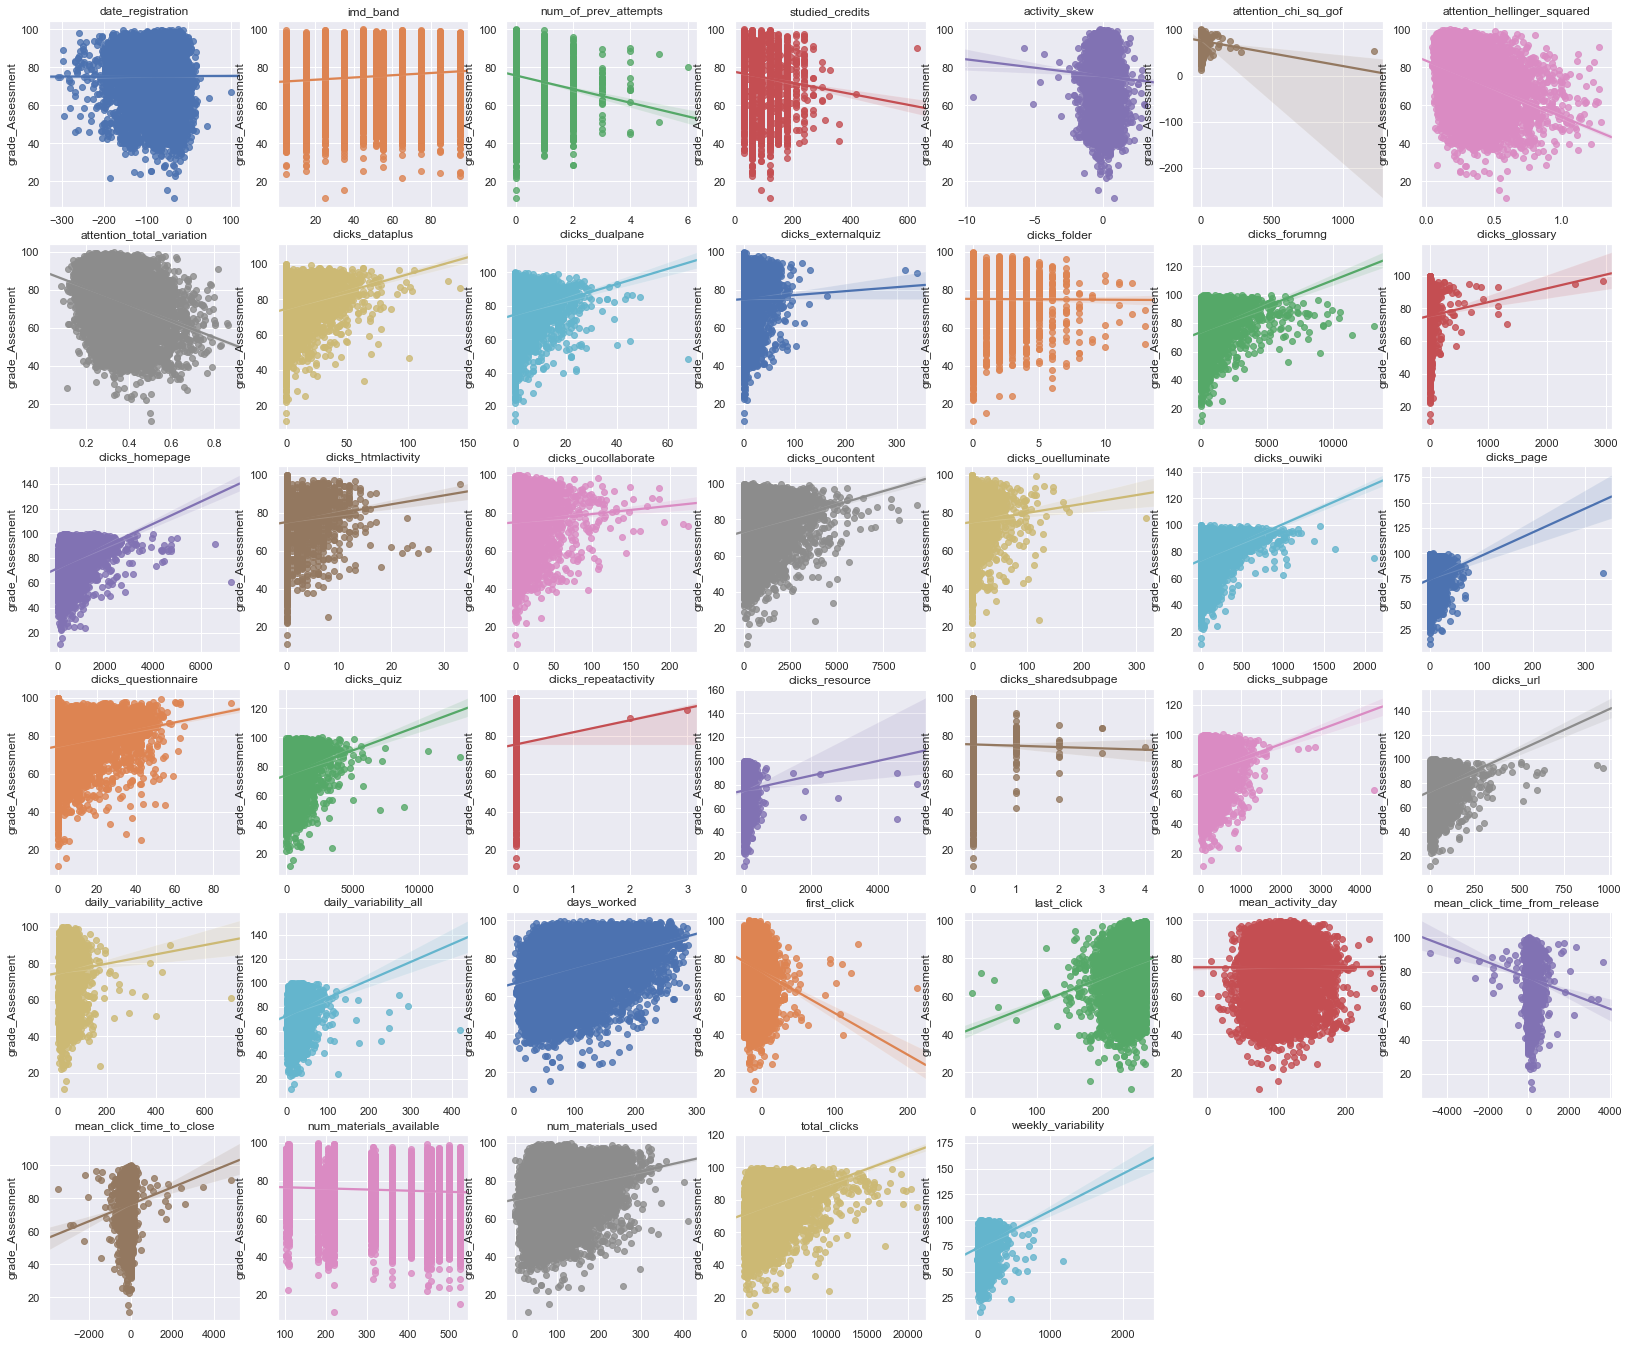

In [13]:
Timer.start()
for col_name, x, ax in continuous_vars:
    sns.regplot(x, df.grade_Assessment, x_ci = 95, ax = ax)

continuous_vars.fig

In [14]:
Timer.end()

48.414 seconds elapsed


In [15]:
categorical_variables = FeaturePlot(df[X_categorical])

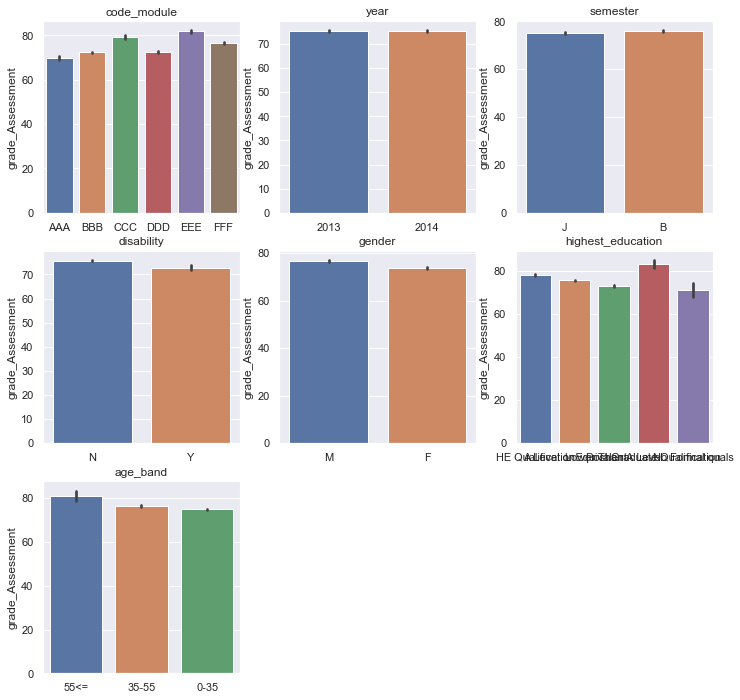

In [16]:
Timer.start()
for col_name, x, ax in categorical_variables:
    sns.barplot(x, df.grade_Assessment, ci = 95, ax = ax)

categorical_variables.fig

In [17]:
Timer.end()

3.84 seconds elapsed


In [18]:
results = []
for x in X_continuous:
    out_dict = {}
    data = df[[x, 'grade_Assessment']].dropna()
    r, p = st.pearsonr(data[x], data.grade_Assessment)
    out_dict['var'] = x
    out_dict['r'] = round(r, 3)
    out_dict['p'] = round(p, 3)
    out_dict['log_p'] = round(np.log(p)/np.log(10), 1)
    results.append(out_dict)

pearsonrs = pd.DataFrame.from_records(results).round(3)
pearsonrs.sort_values('log_p', inplace = True)

/Users/rcharan/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [19]:
pearsonrs

,var,r,p,log_p
30,days_worked,0.347,0.000,-inf
6,attention_hellinger_squared,-0.363,0.000,-inf
7,attention_total_variation,-0.330,0.000,-315.8
38,total_clicks,0.287,0.000,-236.0
14,clicks_homepage,0.260,0.000,-191.8
19,clicks_ouwiki,0.249,0.000,-176.1
37,num_materials_used,0.216,0.000,-131.0
27,clicks_url,0.212,0.000,-126.4
12,clicks_forumng,0.212,0.000,-125.9
17,clicks_oucontent,0.189,0.000,-100.6


## Look at distributions

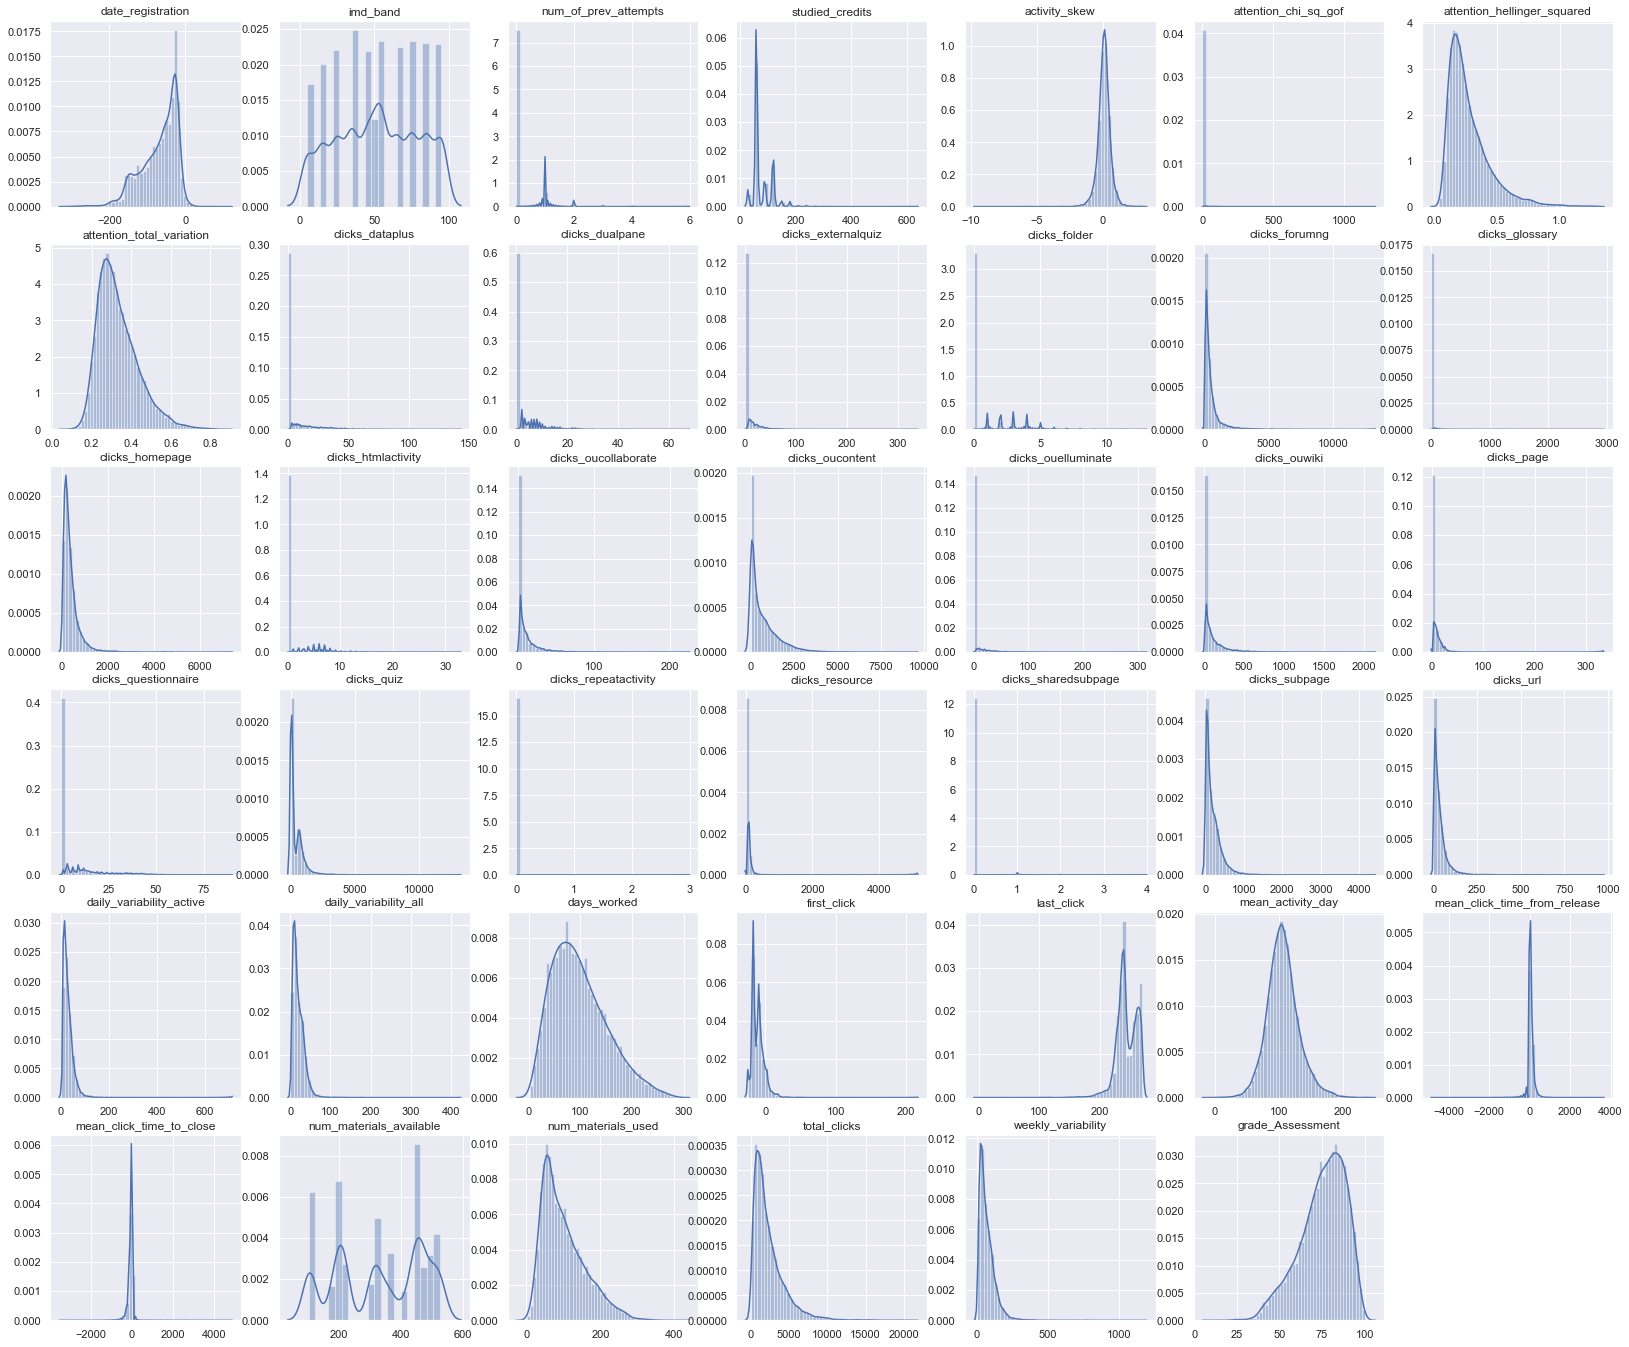

In [20]:
dists = FeaturePlot(df[X_continuous], df[y])

Timer.start()
for col_name, x, ax in dists:
    x = np.array(list(filter(lambda v : not pd.isnull(v), x)))
    sns.distplot(x, ax = ax)

dists.fig

In [21]:
Timer.end()

16.139 seconds elapsed


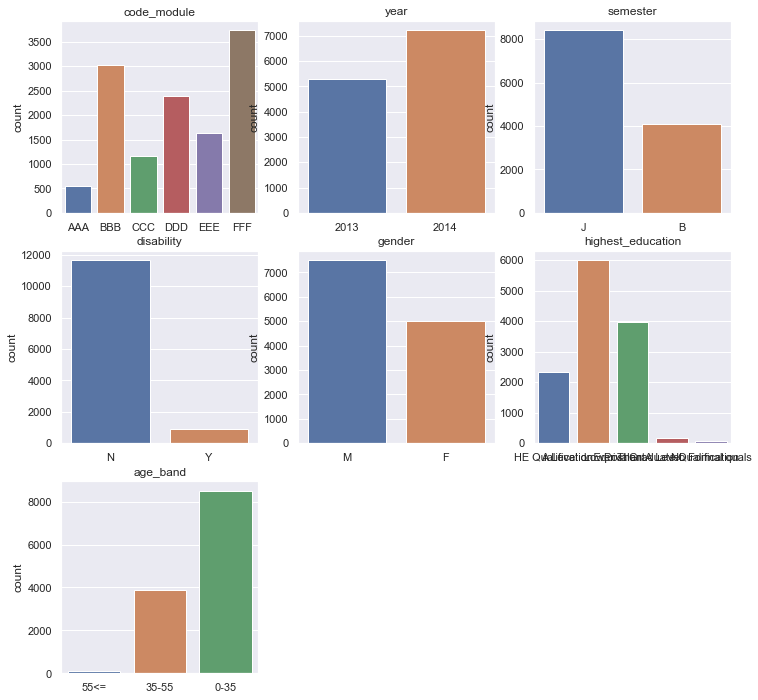

In [22]:
categorical_variables_dist = categorical_variables.clone()
for col, data, ax in categorical_variables_dist:
    sns.countplot(data, ax = ax)
categorical_variables_dist.fig

In [23]:
# Age will create multi-collinearity problems so we recode the two highest age bands together
df.loc[:,'age_band'] = df.age_band.map(lambda band : {
    '55<=' : '35+',
    '35-55': '35+',
    '0-35' : '0-35'
}[band])

# Part 3: Build a simple OLS model as a baseline
 - First, run a regression with everything
 - Second, do some simple feature selection

In [24]:
model = Model('grade_Assessment', X_categorical, X_continuous)
model.remove_var('total_clicks') # Otherwise perfect multi-collinearity

In [25]:
formula = model.formula()
results = smf.ols(formula, df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       grade_Assessment   R-squared:                       0.299
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     81.26
Date:                Fri, 29 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:06:58   Log-Likelihood:                -38705.
No. Observations:               10151   AIC:                         7.752e+04
Df Residuals:                   10097   BIC:                         7.791e+04
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              53.5394      2.599     20.603      0.000      48.446      58.633
C(code_module)[T.BBB]                                   2.1041      0.704      2.990      0.003       0.725       3.483
C(code_module)[T.CCC]                                   8.4606      0.804     10.525      0.000       6.885      10.036
C(code_module)[T.DDD]                                  -9.4579      1.254     -7.543      0.000     -11.916      -7.000
C(code_module)[T.EEE]                                  12.8358      0.837     15.335      0.000      11.195      14.477
C(code_module)[T.FFF]                                 -12.0173      1.567     -7.669      0.000     -15.089      -8.946
C(year)[T.2014]                                         1.5923      0.389      4.089      0.000       0.829       2.356
C(semester)[T.J]                                        0.2470      0.370      0.668      0.504      -0.478       0.972
C(disability)[T.Y]                                     -1.6559      0.442     -3.748      0.000      -2.522      -0.790
C(gender)[T.M]                                          0.8717      0.292      2.988      0.003       0.300       1.444
C(highest_education)[T.HE Qualification]                0.7331      0.305      2.401      0.016       0.134       1.332
C(highest_education)[T.Lower Than A Level]             -2.9102      0.253    -11.519      0.000      -3.405      -2.415
C(highest_education)[T.No Formal quals]                -5.9546      1.583     -3.762      0.000      -9.057      -2.852
C(highest_education)[T.Post Graduate Qualification]     4.4206      0.952      4.645      0.000       2.555       6.286
C(age_band)[T.35+]                                     -0.9501      0.252     -3.776      0.000      -1.443      -0.457
date_registration                                      -0.0003      0.002     -0.107      0.915      -0.005       0.004
imd_band                                                0.0410      0.004     10.109      0.000       0.033       0.049
num_of_prev_attempts                                   -1.3021      0.289     -4.502      0.000      -1.869      -0.735
studied_credits                                        -0.0103      0.003     -3.051      0.002      -0.017      -0.004
activity_skew                                          -2.0229      0.550     -3.678      0.000      -3.101      -0.945
attention_chi_sq_gof                                    0.0104      0.009      1.222      0.222      -0.006       0.027
attention_hellinger_squared                            -6.8017      2.641     -2.576      0.010     -11.978      -1.626
attention_total_variation                             -10.7561      3.904     -2.75

## Analyze Missing Data
There is a substantial amount of non-randomly missing data in two columns, the mean click-time to close and open respectively. This is because some students never used material on which we can measure this.

In [26]:
df[['mean_click_time_from_release', 'mean_click_time_to_close']].isna().groupby('class').sum()

,mean_click_time_from_release,mean_click_time_to_close
class,,
AAA2013J,8.0,8.0
AAA2014J,11.0,11.0
BBB2013B,532.0,532.0
BBB2013J,21.0,21.0
BBB2014B,11.0,11.0
BBB2014J,6.0,6.0
CCC2014B,53.0,53.0
CCC2014J,91.0,91.0
DDD2013B,370.0,370.0


In [27]:
model.remove_var('mean_click_time_to_close', 'mean_click_time_from_release')

In [28]:
formula = model.formula()
results = smf.ols(formula, df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       grade_Assessment   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     95.95
Date:                Fri, 29 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:06:59   Log-Likelihood:                -48123.
No. Observations:               12513   AIC:                         9.635e+04
Df Residuals:                   12461   BIC:                         9.674e+04
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                              58.9579      2.379     24.786      0.000      54.295      63.620
C(code_module)[T.BBB]                                   3.7279      0.669      5.568      0.000       2.416       5.040
C(code_module)[T.CCC]                                   7.8436      0.723     10.853      0.000       6.427       9.260
C(code_module)[T.DDD]                                  -8.6621      1.116     -7.759      0.000     -10.850      -6.474
C(code_module)[T.EEE]                                  11.2348      0.813     13.824      0.000       9.642      12.828
C(code_module)[T.FFF]                                  -6.5265      1.411     -4.624      0.000      -9.293      -3.760
C(year)[T.2014]                                         1.6702      0.337      4.957      0.000       1.010       2.331
C(semester)[T.J]                                        0.3030      0.314      0.965      0.334      -0.312       0.918
C(disability)[T.Y]                                     -1.6274      0.403     -4.035      0.000      -2.418      -0.837
C(gender)[T.M]                                          1.1130      0.262      4.250      0.000       0.600       1.626
C(highest_education)[T.HE Qualification]                1.0080      0.285      3.543      0.000       0.450       1.566
C(highest_education)[T.Lower Than A Level]             -3.0174      0.236    -12.800      0.000      -3.480      -2.555
C(highest_education)[T.No Formal quals]                -4.4348      1.420     -3.123      0.002      -7.218      -1.651
C(highest_education)[T.Post Graduate Qualification]     4.7534      0.878      5.413      0.000       3.032       6.475
C(age_band)[T.35+]                                     -0.8926      0.235     -3.798      0.000      -1.353      -0.432
date_registration                                       0.0015      0.002      0.676      0.499      -0.003       0.006
imd_band                                                0.0405      0.004     10.703      0.000       0.033       0.048
num_of_prev_attempts                                   -1.3103      0.260     -5.040      0.000      -1.820      -0.801
studied_credits                                        -0.0084      0.003     -2.710      0.007      -0.015      -0.002
activity_skew                                          -2.7348      0.501     -5.455      0.000      -3.717      -1.752
attention_chi_sq_gof                                    0.0163      0.009      1.879      0.060      -0.001       0.033
attention_hellinger_squared                           -13.2962      2.325     -5.719      0.000     -17.853      -8.739
attention_total_variation                              -0.0591      3.430     -0.01

## Analyze the Categorical Variables

In [29]:
formula = model.formula(include_cont = False)
results = smf.ols(formula, df).fit()
sm.stats.anova_lm(results, typ = 2)

,sum_sq,df,F,PR(>F)
C(code_module),1.279174e+05,5.0,158.204990,1.519936e-163
C(year),2.557598e+03,1.0,15.815857,7.020833e-05
C(semester),1.089239e+03,1.0,6.735716,9.461174e-03
C(disability),2.589360e+03,1.0,16.012269,6.329631e-05
C(gender),1.712743e+00,1.0,0.010591,9.180325e-01
C(highest_education),3.797249e+04,4.0,58.704245,3.536717e-49
C(age_band),9.434794e+03,1.0,58.343547,2.361227e-14
Residual,2.021064e+06,12498.0,NaN,NaN


In [30]:
# Remove gender
model.remove_var('gender')
formula = model.formula(include_cont = False)
results = smf.ols(formula, df).fit()
sm.stats.anova_lm(results, typ = 2)

,sum_sq,df,F,PR(>F)
C(code_module),1.531309e+05,5.0,189.403302,4.162134e-195
C(year),2.557770e+03,1.0,15.818169,7.012266e-05
C(semester),1.088742e+03,1.0,6.733174,9.474658e-03
C(disability),2.587967e+03,1.0,16.004921,6.354212e-05
C(highest_education),3.801112e+04,4.0,58.768620,3.119914e-49
C(age_band),9.433181e+03,1.0,58.338192,2.367619e-14
Residual,2.021066e+06,12499.0,NaN,NaN


In [31]:
# Interactions
# Type 1 ANOVA table tests the signficance of including each variable 
#  after including *each previous variable*
formula = f'{model.y} ~ C(code_module)*C(semester)*C(year)'
results = smf.ols(formula, df).fit()
sm.stats.anova_lm(results, typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(code_module),5.0,1.543798e+05,30875.966538,188.713235,2.072295e-194
C(semester),1.0,1.299481e+03,1299.480548,7.942397,4.836571e-03
C(year),1.0,2.856662e+03,2856.661690,17.459854,2.954352e-05
C(code_module):C(semester),5.0,1.189350e+04,2378.699145,14.538557,3.103886e-14
C(code_module):C(year),5.0,1.276191e+04,2552.382882,15.600109,2.458566e-15
C(semester):C(year),1.0,3.003272e+02,300.327187,1.835593,1.754928e-01
C(code_module):C(semester):C(year),5.0,7.945613e+03,1589.122518,9.712682,2.840892e-09
Residual,12494.0,2.044183e+06,163.613149,NaN,NaN


In [32]:
# Every class appears to be different in its mean. So we give up and return to just 'class' as a variable
#  Note: this is just reconstructing the class variable currently used as an index
df['class_'] = df[['code_module', 'semester', 'year']].apply(lambda l : ''.join(l), axis = 'columns')

In [33]:
model.remove_var('code_module', 'semester', 'year')
model.add_cat_var('class_')

In [34]:
# We can rule out interactions between the other categorical variables
formula = f'{model.y} ~ C(disability)*C(highest_education)*C(age_band)'
results = smf.ols(formula, df).fit()
sm.stats.anova_lm(results, typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(disability),1.0,6.520619e+03,6520.619474,37.509211,9.371296e-10
C(highest_education),4.0,4.907062e+04,12267.654511,70.568455,3.389135e-59
C(age_band),1.0,3.042977e+03,3042.977439,17.504423,2.885988e-05
C(disability):C(highest_education),4.0,1.397221e+03,349.305154,2.009343,9.028890e-02
C(disability):C(age_band),1.0,4.177975e+02,417.797529,2.403338,1.211019e-01
C(highest_education):C(age_band),4.0,1.503290e+03,375.822378,2.161881,7.060547e-02
C(disability):C(highest_education):C(age_band),4.0,4.930140e+02,123.253505,0.709003,5.856485e-01
Residual,12497.0,2.172485e+06,173.840487,NaN,NaN


In [35]:
# Look for interactions between these other variables and the class
formula = f'{model.y} ~ C(code_module)*(C(disability) + C(highest_education) + C(age_band))'
results = smf.ols(formula, df).fit()
sm.stats.anova_lm(results, typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(code_module),5.0,1.543798e+05,30875.966538,191.373346,4.502906e-197
C(disability),1.0,4.600600e+03,4600.599628,28.515128,9.460107e-08
C(highest_education),4.0,4.140397e+04,10350.993061,64.156831,8.760388e-54
C(age_band),1.0,9.572946e+03,9572.945727,59.334390,1.430631e-14
C(code_module):C(disability),5.0,1.261202e+03,252.240465,1.563420,1.666959e-01
C(code_module):C(highest_education),20.0,7.952737e+03,397.636828,2.464606,2.851484e-04
C(code_module):C(age_band),5.0,3.301632e+03,660.326401,4.092791,1.028742e-03
Residual,12472.0,2.012219e+06,161.338908,NaN,NaN


In [36]:
# It makes sense that the age and education response is different for different
#  classes (which presumably cover different subject matters)
model.add_interaction('C(code_module)', 'highest_education', sep = ':')
model.add_interaction('C(code_module)', 'age_band', sep = ':')

In [37]:
# This is our final choice for categorical variables
formula = model.formula(include_cont = False)
results = smf.ols(formula, df).fit()
sm.stats.anova_lm(results, typ = 1)

,df,sum_sq,mean_sq,F,PR(>F)
C(disability),1.0,6.520619e+03,6520.619474,41.095473,1.502000e-10
C(highest_education),4.0,4.907062e+04,12267.654511,77.315518,7.010193e-65
C(age_band),1.0,3.042977e+03,3042.977439,19.178024,1.200477e-05
C(class_),18.0,1.872200e+05,10401.110881,65.551836,2.811750e-228
C(code_module):C(highest_education),25.0,8.177808e+03,327.112310,2.061589,1.393874e-03
C(code_module):C(age_band),5.0,3.277328e+03,655.465556,4.130998,9.470642e-04
Residual,12464.0,1.977663e+06,158.670017,NaN,NaN


## Backwards Stepwise Selection for Continuous Variables
Remove the worst p-value above a threshold at each step

In [38]:
# Backwards stepwise regression, but only on the continuous variables
def backwards_stepwise(model, pthresh = 0.05):
    model = model.clone_as_baseline()
    def recurse():
        formula       = model.formula()
        results       = smf.ols(formula, df).fit()
        pvalues       = results.pvalues
        relevant_vars = lfilter(lambda x : x in model.X_cont or x in model.get_continuous_interactions(), pvalues.index)
        pvalues       = pvalues[relevant_vars].sort_values(ascending = False)
        worst_p       = pvalues[0]
        if worst_p >= 0.05:
            model.remove_var(pvalues.index[0])
            return recurse()
        else:
            return model
    return recurse()

In [39]:
Timer.start()
new_model = backwards_stepwise(model, pthresh = 0.01)
Timer.end()

5.125 seconds elapsed


In [40]:
formula = new_model.formula()
results = smf.ols(formula, df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       grade_Assessment   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     73.01
Date:                Fri, 29 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:07:08   Log-Likelihood:                -47965.
No. Observations:               12513   AIC:                         9.608e+04
Df Residuals:                   12439   BIC:                         9.663e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  63.1880      1.838     34.385      0.000      59.586      66.790
C(disability)[T.Y]                                                         -1.6111      0.399     -4.043      0.000      -2.392      -0.830
C(highest_education)[T.HE Qualification]                                    1.1431      1.160      0.985      0.324      -1.131       3.417
C(highest_education)[T.Lower Than A Level]                                 -1.2048      1.246     -0.967      0.334      -3.648       1.238
C(highest_education)[T.No Formal quals]                                    -1.9563      1.632     -1.198      0.231      -5.156       1.243
C(highest_education)[T.Post Graduate Qualification]                         6.7258      4.338      1.551      0.121      -1.777      15.228
C(age_band)[T.35+]                                                         -0.8955      0.985     -0.909      0.363      -2.827       1.036
C(class_)[T.AAAJ2014]                                                       0.8380      0.971      0.863      0.388      -1.066       2.742
C(class_)[T.BBBB2013]                                                       2.5888      0.791      3.275      0.001       1.039       4.138
C(class_)[T.BBBB2014]                                                       3.0917      0.799      3.867      0.000       1.525       4.659
C(class_)[T.BBBJ2013]                                                       1.9979      0.738      2.707      0.007       0.551       3.445
C(class_)[T.BBBJ2014]                                                      -0.9416      0.998     -0.943      0.345      -2.898       1.015
C(class_)[T.CCCB2014]                                                       5.2488      1.262      4.160      0.000       2.775       7.722
C(class_)[T.CCCJ2014]                                                       6.3046      1.134      5.560      0.000       4.082       8.527
C(class_)[T.DDDB2013]                                                      -8.3084      0.818    -10.153      0.000      -9.912      -6.704
C(class_)[T.DDDB2014]                                                      -7.1509      0.660    -10.838      0.000      -8.444      -5.858
C(class_)[T.DDDJ2013]                                                      -7.6959      0.567    -13.572      0.000      -8.807      -6.584
C(class_)[T.DDDJ2014]                                                       0.7765      0.745      1.042      0.297      -0.684       2.237
C(class_)[T.EEEB2014]                                                       5.5422      1.255      4.415      0.000       3.082       8.003
C(c

In [41]:
sm.stats.anova_lm(results, typ = 2)

,sum_sq,df,F,PR(>F)
C(disability),2.055565e+03,1.0,16.344491,5.312766e-05
C(highest_education),2.225698e+04,4.0,44.243206,6.128232e-37
C(age_band),2.507942e+03,1.0,19.941498,8.055159e-06
C(class_),3.220531e+05,18.0,142.264077,0.000000e+00
C(code_module):C(highest_education),5.316195e+05,25.0,169.083489,0.000000e+00
C(code_module):C(age_band),1.673248e+03,5.0,2.660912,2.073183e-02
imd_band,1.441097e+04,1.0,114.586549,1.265900e-26
num_of_prev_attempts,3.444021e+03,1.0,27.384577,1.694681e-07
studied_credits,1.248323e+03,1.0,9.925841,1.633606e-03
activity_skew,5.175698e+03,1.0,41.153731,1.458138e-10


## Look at how much the click granularity is useful

In [42]:
# It looks like the specific materials clicked on
#  are more important than just the total number of clicks

def is_click_var(var):
    return var.startswith('clicks_')
click_vars_in_model = filter(is_click_var, new_model.X_cont)

click_model = new_model.clone_as_baseline()
for var in click_vars_in_model:
    click_model.remove_var(var)
click_model.add_cont_var('total_clicks')

formula = click_model.formula()
results = smf.ols(formula, df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       grade_Assessment   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     80.46
Date:                Fri, 29 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:07:09   Log-Likelihood:                -48117.
No. Observations:               12513   AIC:                         9.636e+04
Df Residuals:                   12451   BIC:                         9.682e+04
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  64.3273      1.840     34.959      0.000      60.721      67.934
C(disability)[T.Y]                                                         -1.6031      0.403     -3.979      0.000      -2.393      -0.813
C(highest_education)[T.HE Qualification]                                    1.0952      1.173      0.933      0.351      -1.205       3.395
C(highest_education)[T.Lower Than A Level]                                 -1.1894      1.261     -0.943      0.346      -3.661       1.282
C(highest_education)[T.No Formal quals]                                    -1.9897      1.651     -1.205      0.228      -5.226       1.246
C(highest_education)[T.Post Graduate Qualification]                         7.0581      4.389      1.608      0.108      -1.544      15.660
C(age_band)[T.35+]                                                         -1.4142      0.992     -1.426      0.154      -3.358       0.529
C(class_)[T.AAAJ2014]                                                       0.7575      0.982      0.771      0.441      -1.168       2.682
C(class_)[T.BBBB2013]                                                       2.5572      0.790      3.236      0.001       1.008       4.106
C(class_)[T.BBBB2014]                                                       2.9728      0.803      3.701      0.000       1.398       4.547
C(class_)[T.BBBJ2013]                                                       1.8254      0.739      2.469      0.014       0.376       3.275
C(class_)[T.BBBJ2014]                                                      -0.4135      1.001     -0.413      0.680      -2.376       1.549
C(class_)[T.CCCB2014]                                                       5.4971      1.267      4.340      0.000       3.014       7.980
C(class_)[T.CCCJ2014]                                                       6.5975      1.139      5.791      0.000       4.364       8.831
C(class_)[T.DDDB2013]                                                      -6.3503      0.739     -8.595      0.000      -7.799      -4.902
C(class_)[T.DDDB2014]                                                      -6.0331      0.652     -9.253      0.000      -7.311      -4.755
C(class_)[T.DDDJ2013]                                                      -6.3978      0.554    -11.542      0.000      -7.484      -5.311
C(class_)[T.DDDJ2014]                                                       0.2999      0.726      0.413      0.680      -1.124       1.724
C(class_)[T.EEEB2014]                                                       7.0546      1.258      5.608      0.000       4.589       9.521
C(c

# Part 4: Diagnosis the regression

## Deal with (multi)-collinearity

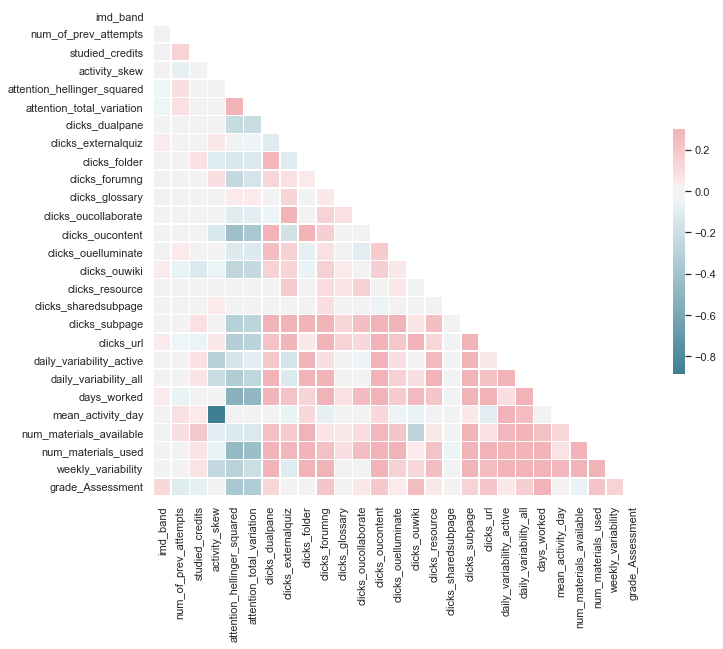

In [43]:
# The correlation matrix for the variables reatined isn't too bad.
#  This is unsurprising since inflated p-values would have removed many variables
sns.set_style('white')
correlation_matrix(df[new_model.X_cont + [new_model.y]])

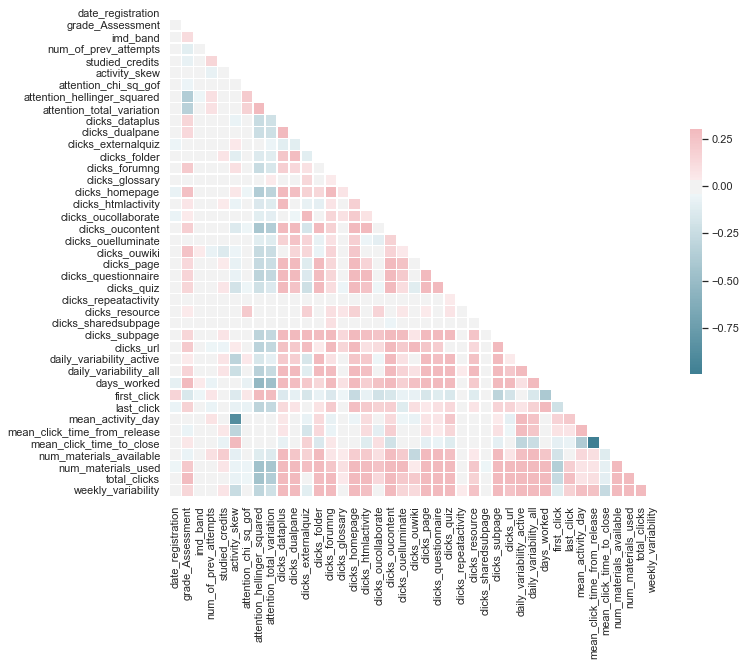

In [44]:
# Compare the full dataset. Also suprisingly not that bad
#  This is quite surprising since many of our features
#  are meant to be alternate measures of the same thing.
correlation_matrix(df)

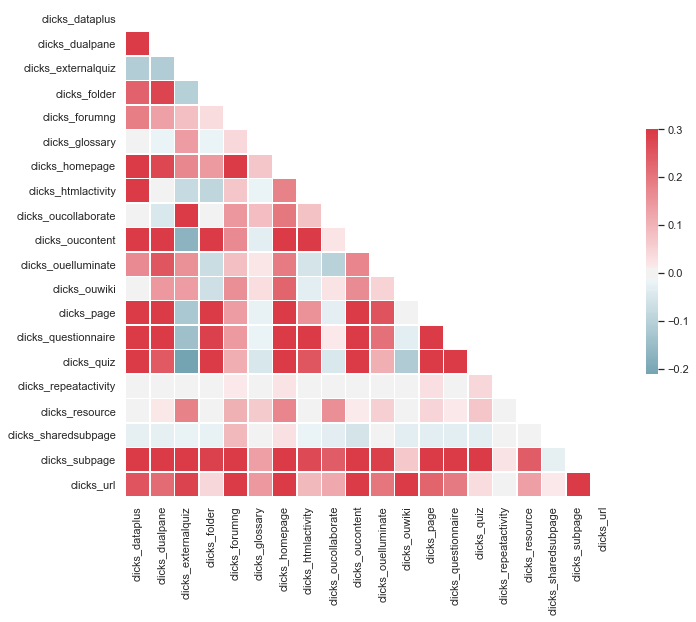

In [45]:
# also, it will behoove us to focus in on the clicks.
#  Note that many correlations are likely to be driven by
#  the different classes. (results not shown)
click_vars = lfilter(is_click_var, df.columns)
correlation_matrix(df[click_vars])

In [46]:
new_model.X_cat

['disability', 'highest_education', 'age_band', 'class_']

Finally, we will examine variance inflation factors

In [47]:
one_hot = pd.get_dummies(df[new_model.X_cont + ['class_', 'highest_education']], drop_first = True)

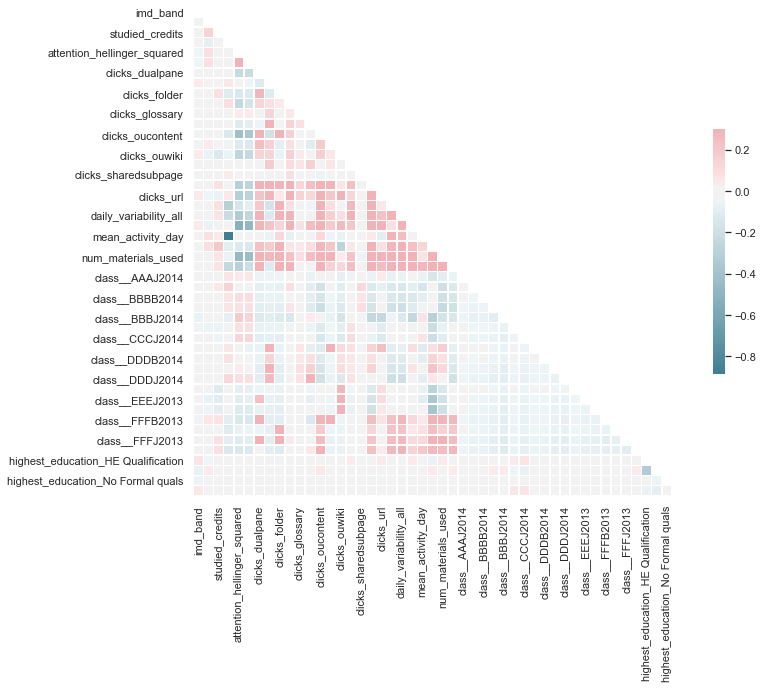

In [48]:
correlation_matrix(one_hot)

In [49]:
vif_table(one_hot)

num_materials_available                          672.614951
class__FFFJ2013                                   64.567799
class__FFFB2013                                   43.484583
class__FFFJ2014                                   39.325803
class__FFFB2014                                   30.793264
daily_variability_all                             30.710071
class__DDDJ2013                                   30.358710
daily_variability_active                          19.067388
class__DDDJ2014                                   17.544326
class__DDDB2014                                   15.791593
attention_hellinger_squared                       14.036009
weekly_variability                                13.088732
class__DDDB2013                                   12.231151
attention_total_variation                         12.062827
class__BBBJ2013                                   11.016060
class__BBBB2013                                    7.983713
num_materials_used                      

In [50]:
# Only continuous variables will be dropped.
#  Returns a list of variables to drop
def drop_high_vif(df_one_hot, cont_var_list, vif_thresh = 10, verbose = True):
    to_drop = []
    df_one_hot    = df_one_hot.copy()
    cont_var_list = cont_var_list.copy()
    def recurse():
        table       = vif_table(df_one_hot)
        cont_table  = table[cont_var_list].sort_values(ascending = False)
        if cont_table[0] > vif_thresh:
            drop_var = cont_table.index[0]
            drop_col(df_one_hot, drop_var)
            cont_var_list.remove(drop_var)
            to_drop.append(drop_var)
            if verbose:
                print(f'Dropping {drop_var}')
            return recurse()
        else:
            return table
    
    table = recurse()
    
    return to_drop, df_one_hot, table
            

In [51]:
Timer.start()
to_drop, _, table = drop_high_vif(one_hot, new_model.X_cont)
Timer.end()

Dropping num_materials_available
Dropping attention_total_variation
Dropping daily_variability_all
Dropping mean_activity_day
Dropping weekly_variability
Dropping num_materials_used
Dropping days_worked
16.923 seconds elapsed


In [52]:
table

clicks_subpage                                   7.156113
studied_credits                                  6.020919
clicks_oucontent                                 5.316392
daily_variability_active                         5.191567
attention_hellinger_squared                      4.801176
class__FFFJ2013                                  4.740987
imd_band                                         4.326027
clicks_folder                                    3.774627
clicks_url                                       3.202369
class__FFFB2013                                  3.147661
class__FFFJ2014                                  3.134406
clicks_ouwiki                                    3.105175
class__FFFB2014                                  2.876268
clicks_externalquiz                              2.589300
class__BBBJ2014                                  2.522186
class__DDDJ2014                                  2.470564
clicks_dualpane                                  2.318664
class__DDDJ201

In [53]:
new_model.remove_var(*to_drop)

In [104]:
formula = new_model.formula()
results = smf.ols(formula, df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       grade_Assessment   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     67.55
Date:                Fri, 29 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:24:51   Log-Likelihood:                -48255.
No. Observations:               12513   AIC:                         9.665e+04
Df Residuals:                   12445   BIC:                         9.715e+04
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  74.5436      1.090     68.383      0.000      72.407      76.680
C(disability)[T.Y]                                                         -1.3028      0.407     -3.199      0.001      -2.101      -0.504
C(highest_education)[T.HE Qualification]                                    1.1987      1.187      1.010      0.312      -1.128       3.525
C(highest_education)[T.Lower Than A Level]                                 -1.3157      1.275     -1.032      0.302      -3.815       1.183
C(highest_education)[T.No Formal quals]                                    -0.4313      1.617     -0.267      0.790      -3.600       2.738
C(highest_education)[T.Post Graduate Qualification]                         6.2161      4.438      1.401      0.161      -2.483      14.915
C(age_band)[T.35+]                                                         -1.0988      1.007     -1.091      0.275      -3.072       0.875
C(class_)[T.AAAJ2014]                                                      -0.1797      0.984     -0.183      0.855      -2.109       1.750
C(class_)[T.BBBB2013]                                                       3.5236      0.947      3.719      0.000       1.666       5.381
C(class_)[T.BBBB2014]                                                       4.3783      0.951      4.604      0.000       2.514       6.243
C(class_)[T.BBBJ2013]                                                       3.3537      0.916      3.663      0.000       1.559       5.148
C(class_)[T.BBBJ2014]                                                      -1.1915      0.890     -1.339      0.180      -2.935       0.552
C(class_)[T.CCCB2014]                                                       5.6470      1.212      4.658      0.000       3.270       8.024
C(class_)[T.CCCJ2014]                                                       8.0699      1.175      6.870      0.000       5.767      10.373
C(class_)[T.DDDB2013]                                                      -1.6217      1.050     -1.545      0.122      -3.679       0.436
C(class_)[T.DDDB2014]                                                      -0.4051      0.967     -0.419      0.675      -2.300       1.489
C(class_)[T.DDDJ2013]                                                      -0.5637      0.904     -0.623      0.533      -2.336       1.209
C(class_)[T.DDDJ2014]                                                       2.5874      0.910      2.843      0.004       0.803       4.372
C(class_)[T.EEEB2014]                                                       1.9067      1.140      1.673      0.094      -0.328       4.141
C(c

## Residual diagnosis
Looking at the above, we clearly have skewed residuals

In [105]:
sns.set_style('darkgrid')

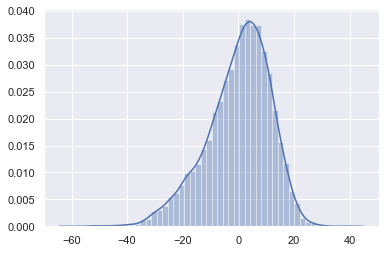

In [106]:
plot(sns.distplot, results.resid)

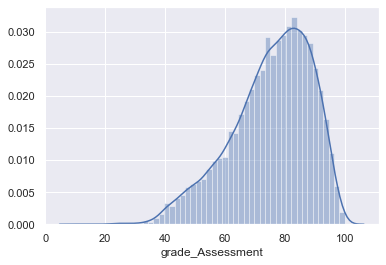

In [107]:
plot(sns.distplot, df[new_model.y])

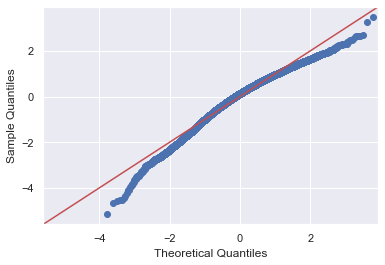

In [108]:
sm.graphics.qqplot(results.resid, fit = True, line = '45')

In [66]:
import scipy.stats as st

In [109]:
df['grade_boxcox'], lambda_ = st.boxcox(df[new_model.y])
lambda_

2.3813039444047712

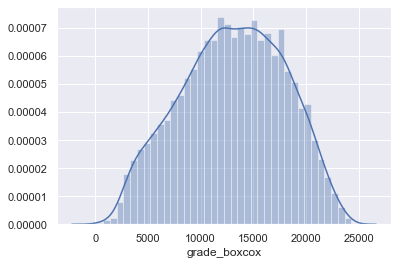

In [110]:
plot(sns.distplot, df['grade_boxcox'])

In [111]:
resid_normal = new_model.clone_as_baseline()

In [112]:
resid_normal.y = 'grade_boxcox'

In [169]:
# This leads to some improvement
#  Also note that some variables stop being signficant
formula = resid_normal.formula()
results = smf.ols(formula, df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           grade_boxcox   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     72.15
Date:                Fri, 29 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:07:35   Log-Likelihood:            -1.2204e+05
No. Observations:               12513   AIC:                         2.442e+05
Df Residuals:                   12445   BIC:                         2.447e+05
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                1.218e+04    396.545     30.723      0.000    1.14e+04     1.3e+04
C(disability)[T.Y]                                                       -406.6455    148.164     -2.745      0.006    -697.070    -116.221
C(highest_education)[T.HE Qualification]                                  383.0381    431.702      0.887      0.375    -463.165    1229.241
C(highest_education)[T.Lower Than A Level]                               -413.2479    463.811     -0.891      0.373   -1322.390     495.894
C(highest_education)[T.No Formal quals]                                  -158.6337    588.125     -0.270      0.787   -1311.450     994.183
C(highest_education)[T.Post Graduate Qualification]                      2219.1596   1614.337      1.375      0.169    -945.191    5383.511
C(age_band)[T.35+]                                                       -518.0289    366.247     -1.414      0.157   -1235.930     199.872
C(class_)[T.AAAJ2014]                                                       0.2561    358.058      0.001      0.999    -701.592     702.105
C(class_)[T.BBBB2013]                                                    1351.9659    344.663      3.923      0.000     676.373    2027.559
C(class_)[T.BBBB2014]                                                    1615.5574    345.969      4.670      0.000     937.404    2293.711
C(class_)[T.BBBJ2013]                                                    1183.2673    333.035      3.553      0.000     530.467    1836.068
C(class_)[T.BBBJ2014]                                                    -295.9074    323.592     -0.914      0.361    -930.198     338.383
C(class_)[T.CCCB2014]                                                    2453.5428    441.048      5.563      0.000    1589.021    3318.064
C(class_)[T.CCCJ2014]                                                    3412.5474    427.333      7.986      0.000    2574.908    4250.186
C(class_)[T.DDDB2013]                                                    -400.8549    381.792     -1.050      0.294   -1149.226     347.516
C(class_)[T.DDDB2014]                                                     127.8071    351.593      0.364      0.716    -561.369     816.983
C(class_)[T.DDDJ2013]                                                       8.8699    328.974      0.027      0.978    -635.969     653.709
C(class_)[T.DDDJ2014]                                                    1251.8829    331.118      3.781      0.000     602.840    1900.926
C(class_)[T.EEEB2014]                                                     798.1887    414.677      1.925      0.054     -14.643    1611.021
C(c

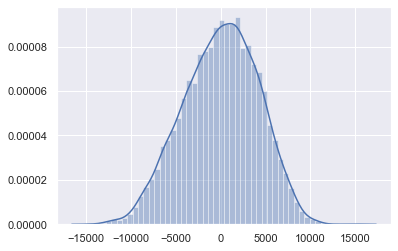

In [114]:
plot(sns.distplot, results.resid)

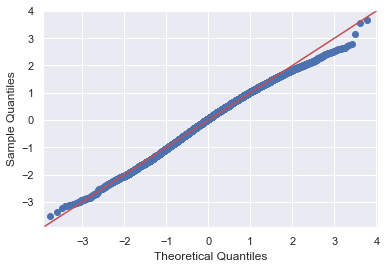

In [115]:
sm.graphics.qqplot(results.resid, fit = True, line = '45')

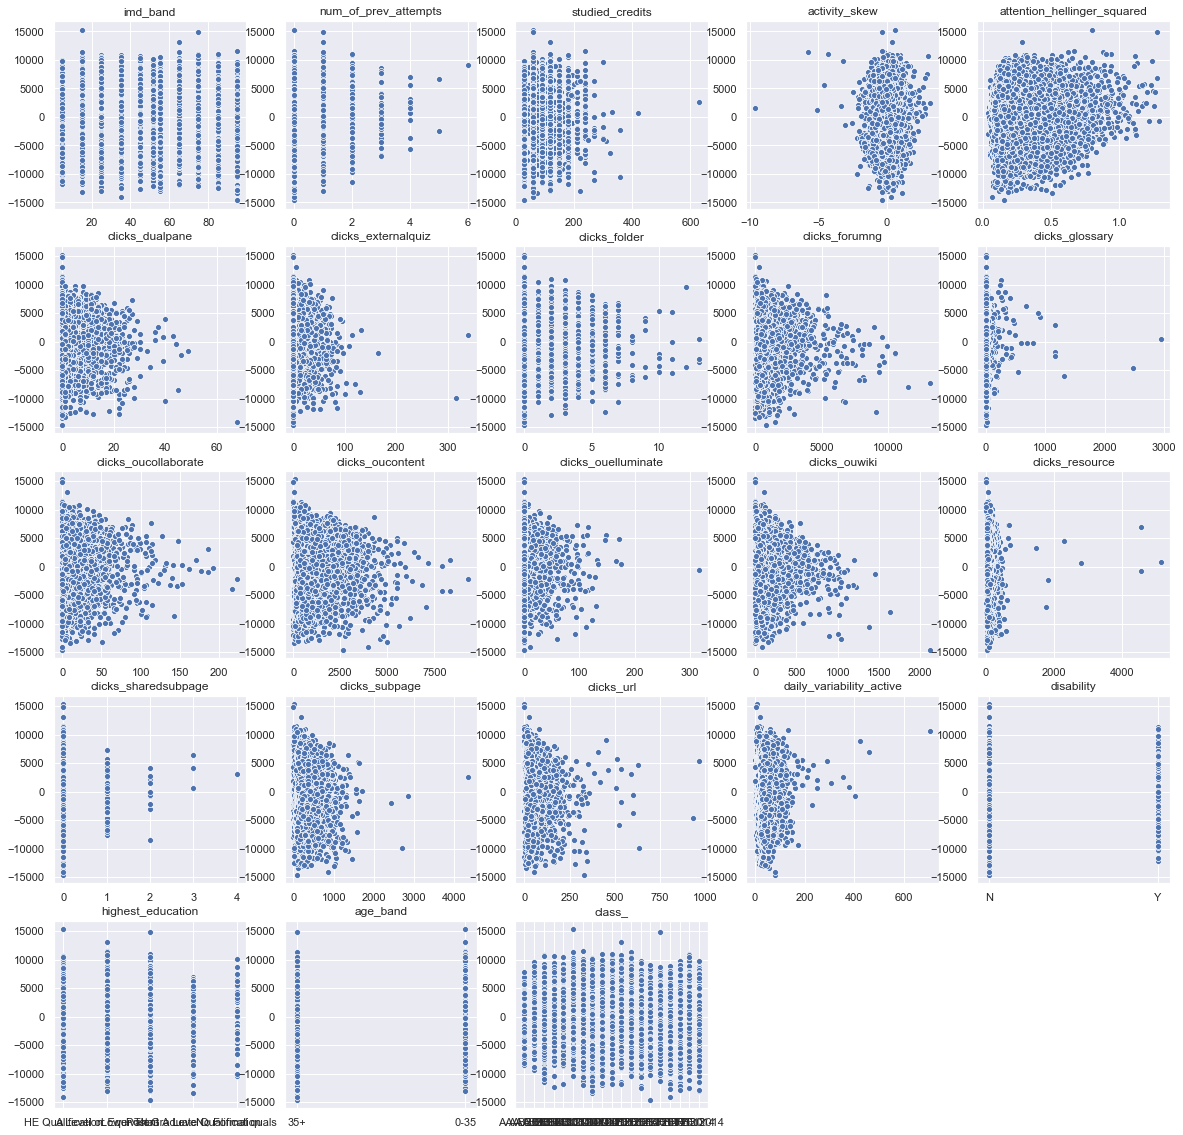

In [128]:
resid_plot = FeaturePlot(df[resid_normal.X_cont + resid_normal.X_cat])

for col, data, ax in resid_plot:
    sns.scatterplot(data, results.resid, ax = ax)

# Linearity looks okay; heteroskedasticity is a problem
resid_plot.fig

In [116]:
# The third result is an f score. 2nd and 4th are p-values indistinguishable from 0
sm.stats.diagnostic.het_breuschpagan(results.resid, df[resid_normal.X_cont])

(4806.558935547364, 0.0, 410.1363961479939, 0.0)

In [126]:
# To fix, we can attempt to transform the regressors
boxcox_xy = resid_normal.clone_as_baseline()
for var in boxcox_xy.X_cont.copy():
    try:
        new_name = var + '_boxcox'
        if var.startswith('clicks_'):
            shift = 1
        else:
            shift = 0
        df[new_name], lambda_ = st.boxcox(df[var] + shift)
        print(f'lambda = {lambda_} for {var}')
        boxcox_xy.remove_var(var)
        boxcox_xy.add_cont_var(new_name)
    except ValueError:
        print(f'Unable to transform {var}')

lambda = 0.7923942650798255 for imd_band
Unable to transform num_of_prev_attempts
lambda = -0.29866978913228587 for studied_credits
Unable to transform activity_skew
lambda = -0.13677387071394784 for attention_hellinger_squared
lambda = -2.268655680884783 for clicks_dualpane
lambda = -1.9830722455084087 for clicks_externalquiz
lambda = -5.5485661452679205 for clicks_folder
lambda = 0.17207094309677234 for clicks_forumng
lambda = -1.8084548987699594 for clicks_glossary
lambda = -0.4252057613294365 for clicks_oucollaborate
lambda = 0.23081959592176576 for clicks_oucontent
lambda = -3.706269350521899 for clicks_ouelluminate
lambda = -0.16397541224474171 for clicks_ouwiki
lambda = 0.1048321635319503 for clicks_resource
lambda = -226.34442612192157 for clicks_sharedsubpage
lambda = 0.18945002283059265 for clicks_subpage
lambda = 0.15804066046930892 for clicks_url
lambda = -0.007813282275591762 for daily_variability_active


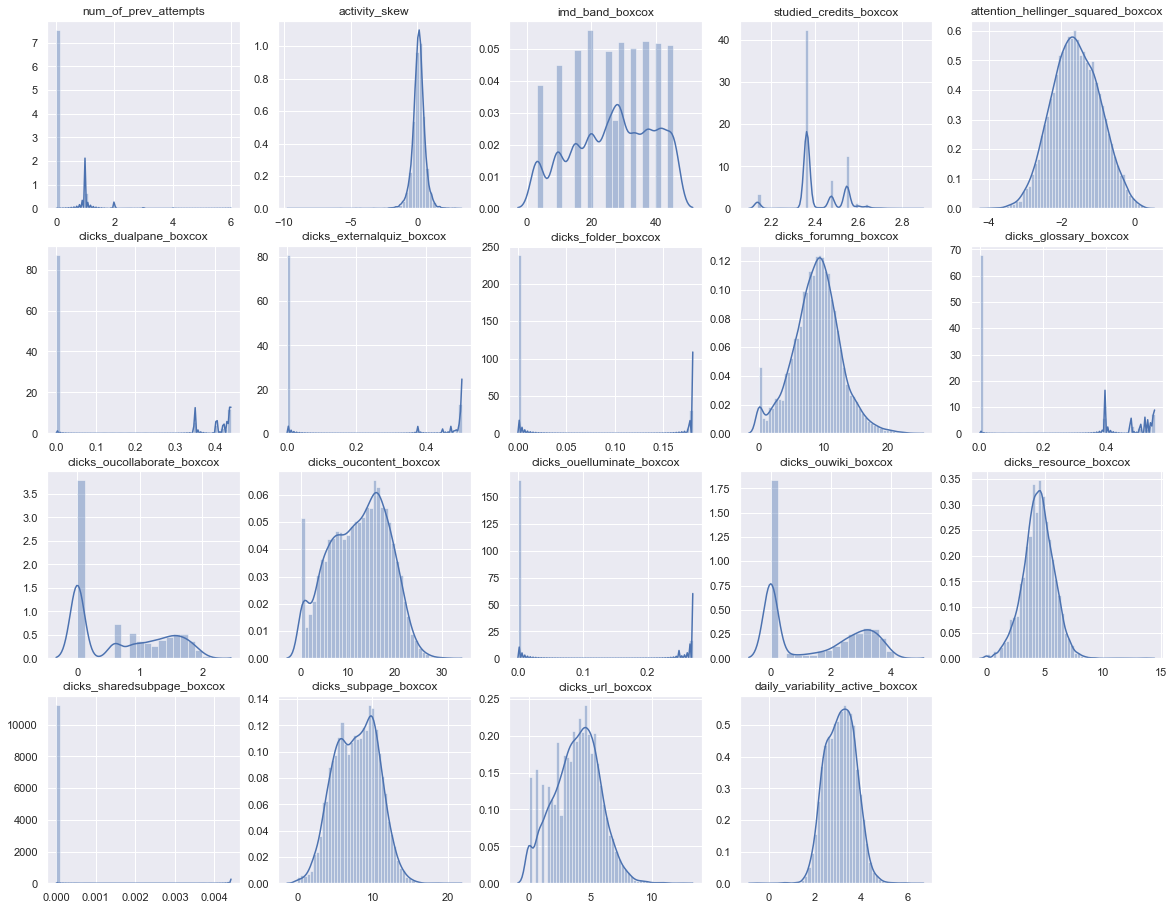

In [127]:
boxcox_plot = FeaturePlot(df[boxcox_xy.X_cont])
for col, data, ax in boxcox_plot:
    sns.distplot(data, ax = ax)
boxcox_plot.fig

In [129]:
# This leads to some improvement
formula = boxcox_xy.formula()
results = smf.ols(formula, df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           grade_boxcox   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     76.49
Date:                Fri, 29 Nov 2019   Prob (F-statistic):               0.00
Time:                        11:37:26   Log-Likelihood:            -1.2193e+05
No. Observations:               12513   AIC:                         2.440e+05
Df Residuals:                   12445   BIC:                         2.445e+05
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                6760.3205   1031.191      6.556      0.000    4739.026    8781.615
C(disability)[T.Y]                                                       -439.7145    147.061     -2.990      0.003    -727.977    -151.452
C(highest_education)[T.HE Qualification]                                  415.2452    428.149      0.970      0.332    -423.993    1254.484
C(highest_education)[T.Lower Than A Level]                               -362.1060    459.955     -0.787      0.431   -1263.690     539.478
C(highest_education)[T.No Formal quals]                                  -743.9253    587.186     -1.267      0.205   -1894.901     407.051
C(highest_education)[T.Post Graduate Qualification]                      2725.5255   1600.990      1.702      0.089    -412.662    5863.712
C(age_band)[T.35+]                                                       -411.3916    363.564     -1.132      0.258   -1124.033     301.249
C(class_)[T.AAAJ2014]                                                     172.8586    355.371      0.486      0.627    -523.723     869.440
C(class_)[T.BBBB2013]                                                    1332.6228    380.166      3.505      0.000     587.439    2077.807
C(class_)[T.BBBB2014]                                                    1357.5160    353.055      3.845      0.000     665.473    2049.559
C(class_)[T.BBBJ2013]                                                     921.6484    342.380      2.692      0.007     250.530    1592.766
C(class_)[T.BBBJ2014]                                                    1046.4828    344.204      3.040      0.002     371.790    1721.176
C(class_)[T.CCCB2014]                                                    2930.4555    453.097      6.468      0.000    2042.316    3818.595
C(class_)[T.CCCJ2014]                                                    3827.5462    438.807      8.723      0.000    2967.416    4687.677
C(class_)[T.DDDB2013]                                                   -2747.7710    506.685     -5.423      0.000   -3740.953   -1754.589
C(class_)[T.DDDB2014]                                                   -2178.7262    430.926     -5.056      0.000   -3023.408   -1334.044
C(class_)[T.DDDJ2013]                                                   -2400.9738    419.622     -5.722      0.000   -3223.498   -1578.450
C(class_)[T.DDDJ2014]                                                    1196.7842    395.756      3.024      0.002     421.041    1972.527
C(class_)[T.EEEB2014]                                                      11.3661    442.333      0.026      0.980    -855.674     878.406
C(c

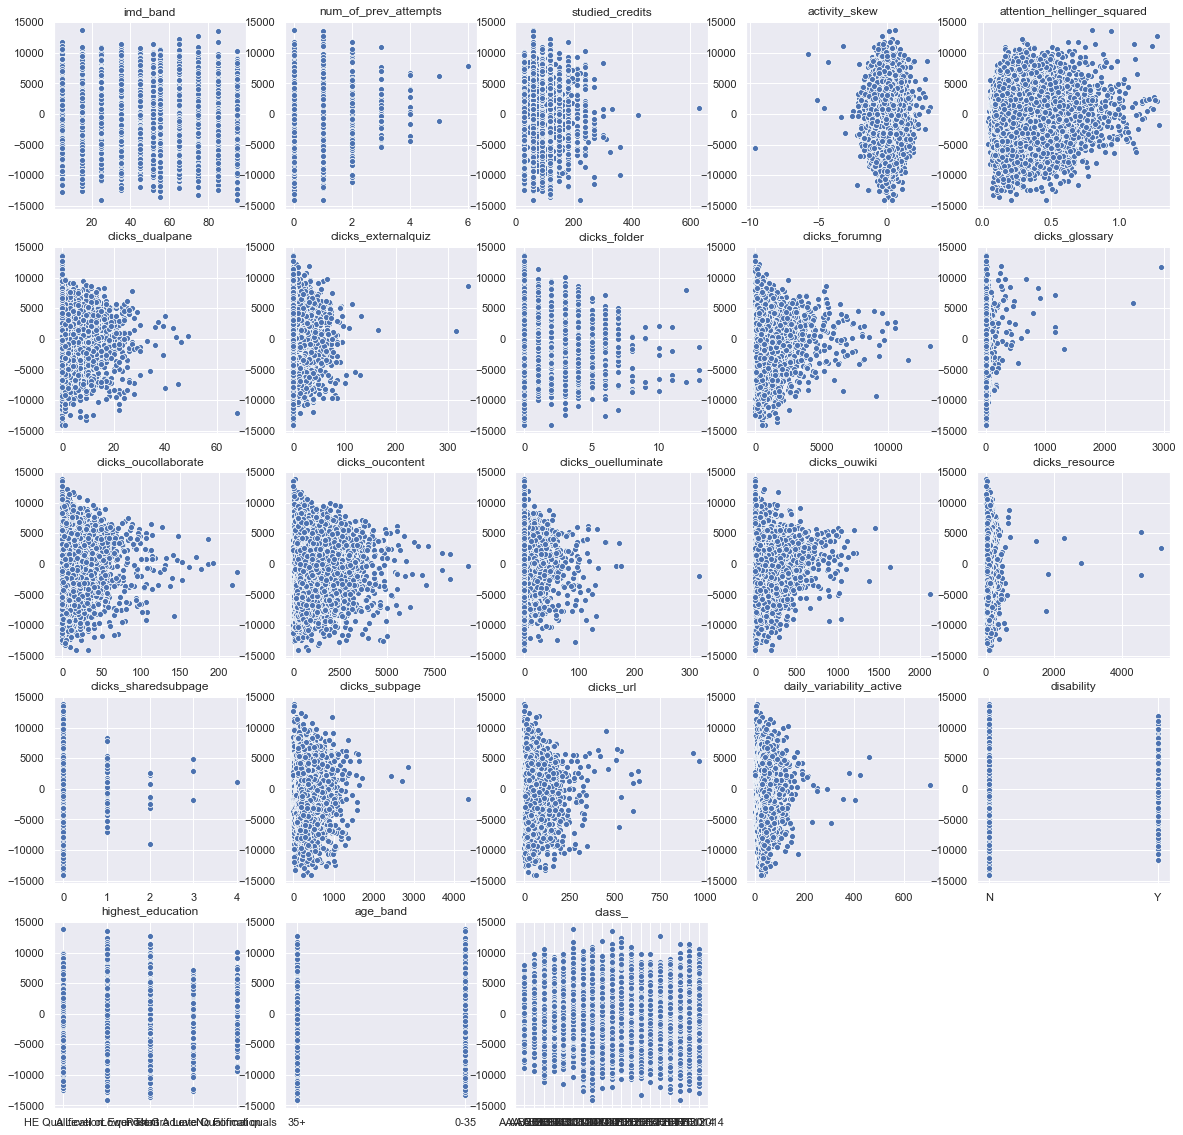

In [130]:
# This didn't really help
resid_plot = FeaturePlot(df[resid_normal.X_cont + resid_normal.X_cat])

for col, data, ax in resid_plot:
    sns.scatterplot(data, results.resid, ax = ax)

# Linearity looks okay; heteroskedasticity is a problem
resid_plot.fig

## Outlier Analysis
Outliers don't appear to be a major issue

In [ ]:
# Our standing model is resid_normal, let's restore that
resid_normal.formula()
results = smf.ols(formula, df).fit()

In [135]:
from statsmodels.stats.outliers_influence import  OLSInfluence

In [137]:
influence_obj = OLSInfluence(results)

In [139]:
student_resids = influence_obj.resid_studentized

In [140]:
leverage = influence_obj.hat_matrix_diag

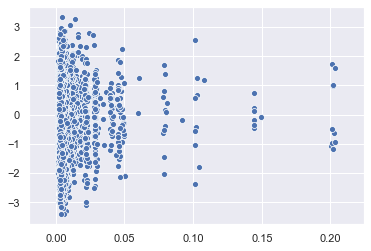

In [143]:
plot(sns.scatterplot, leverage, student_resids)

In [150]:
cooks, pvals = influence_obj.cooks_distance

In [153]:
pd.Series(pvals).describe()

count    12513.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
dtype: float64

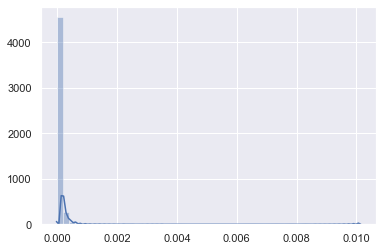

In [155]:
plot(sns.distplot, cooks)

# Part 5: Interaction terms

In [170]:
# Restore our baseline model
model = backwards_stepwise(resid_normal)
formula = model.formula()
results = smf.ols(formula, df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           grade_boxcox   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     77.76
Date:                Fri, 29 Nov 2019   Prob (F-statistic):               0.00
Time:                        12:08:01   Log-Likelihood:            -1.2204e+05
No. Observations:               12513   AIC:                         2.442e+05
Df Residuals:                   12450   BIC:                         2.447e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
===========================================================================================================================================
                                                                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                1.201e+04    379.620     31.643      0.000    1.13e+04    1.28e+04
C(disability)[T.Y]                                                       -409.0772    148.090     -2.762      0.006    -699.357    -118.797
C(highest_education)[T.HE Qualification]                                  385.8931    431.772      0.894      0.371    -460.448    1232.234
C(highest_education)[T.Lower Than A Level]                               -418.3300    463.898     -0.902      0.367   -1327.643     490.983
C(highest_education)[T.No Formal quals]                                  -144.7232    588.030     -0.246      0.806   -1297.352    1007.906
C(highest_education)[T.Post Graduate Qualification]                      2234.5674   1614.610      1.384      0.166    -930.317    5399.452
C(age_band)[T.35+]                                                       -462.2713    364.222     -1.269      0.204   -1176.203     251.661
C(class_)[T.AAAJ2014]                                                       3.5789    357.931      0.010      0.992    -698.022     705.180
C(class_)[T.BBBB2013]                                                    1342.8934    344.182      3.902      0.000     668.243    2017.544
C(class_)[T.BBBB2014]                                                    1642.9421    345.903      4.750      0.000     964.918    2320.966
C(class_)[T.BBBJ2013]                                                    1224.0466    332.825      3.678      0.000     571.659    1876.434
C(class_)[T.BBBJ2014]                                                    -313.2949    321.530     -0.974      0.330    -943.543     316.953
C(class_)[T.CCCB2014]                                                    2477.7323    439.936      5.632      0.000    1615.389    3340.075
C(class_)[T.CCCJ2014]                                                    3439.0591    426.546      8.063      0.000    2602.963    4275.155
C(class_)[T.DDDB2013]                                                    -458.4783    368.769     -1.243      0.214   -1181.322     264.366
C(class_)[T.DDDB2014]                                                     151.4954    350.774      0.432      0.666    -536.077     839.067
C(class_)[T.DDDJ2013]                                                      22.0700    327.869      0.067      0.946    -620.605     664.745
C(class_)[T.DDDJ2014]                                                    1293.0616    324.915      3.980      0.000     656.179    1929.944
C(class_)[T.EEEB2014]                                                     833.4007    413.844      2.014      0.044      22.202    1644.600
C(c

# Next Steps

## Software

The 'model' class developed in utilities.py is very helpful by letting us keep track of what is in and out of our model at any given time. Future enhancements could include:
- Named states that can be restored
- Internalizing the fitting of an OLS model
- Stronger support for interactions
- Internalizing many of the common tasks used here (correlation matricies, backwards stepwise regression, distribution plots, residual plots, qqplots, etc.)